# Notebook to Analyze Beam Profiles

In [160]:
import numpy as np
import numpy.random as rand
from scipy.constants import codata
from scipy.interpolate import interp1d, interp2d
from todloop.utils.pixels import PixelReader
from todloop.base import Routine, TODLoop
import cPickle
import os
import pprint
from todloop.utils.cuts import pixels_affected_in_event
from plot_glitches.routines import PlotGlitches
import moby2
from moby2.scripting import get_filebase
from random import *
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/act3/users/jpm136/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['choice', 'uniform', 'shuffle', 'sample', 'f', 'rand', 'seed', 'randint', 'random', 'triangular']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Import Relevant TOD Data

In [2]:
"""
Change tod variable to track you want to analyze below!

"""

tod = 10000
input_dir="../outputs/s16_pa3_list/cosig/"
postfix = "pickle"
filepath = "%s%s.%s" % (input_dir, tod, postfix)
if os.path.isfile(filepath):
    with open(filepath, "r") as f:
        cuts = cPickle.load(f)
else:
    print 'Cosig data NOT loaded!'

fb = get_filebase()
loop = TODLoop()
loop.add_tod_list("../data/s16_pa3_list.txt")
loop.run(tod,tod+1)
tod_name = loop.get_name()
tod_filename = fb.filename_from_name(tod_name, single=True)  # get file path
tod_data = moby2.scripting.get_tod({'filename': tod_filename, 'repair_pointing': True})
amdata = moby2.scripting.get_array_data({'season' : '2016','array_name': 'AR3'})
sky_x = amdata['sky_x']
sky_y = amdata['sky_y']

#fix optical sign
optical_signs = tod_data.info.array_data['optical_sign']
tod_data.data = tod_data.data*optical_signs[:, np.newaxis]

#calibrate
cal = moby2.scripting.get_calibration({'type': 'iv', 'source': 'data'}, tod=tod_data)
cal_mask, cal_val = cal.get_property('cal', det_uid=tod_data.det_uid)
tod_data.data *= cal_val[:,None]
    

## Load Beam Profile for Array 3, 90 GHz 
After loading the profile, set the variables `pa3_90x` and `pa3_90y` to columns of beam profile text file so that they can be interpolated as a function. 
<br>
For example, if you want to know what the value of the profile is at a certain angular separation $x$ , you can call this function $f(x)$ to return its $y$-value.

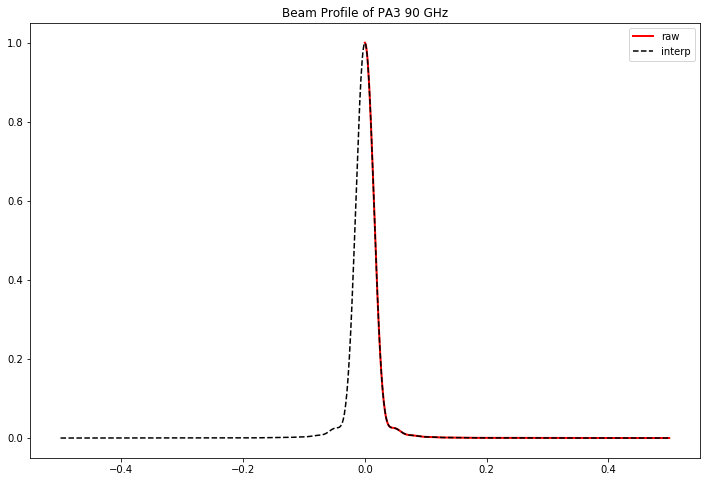

481

In [191]:
Beam_PA3_90 = np.loadtxt('beam_profile_170112_2015_pa3_90GHz_instant.txt', unpack=True, delimiter='  ', skiprows=4)

pa3_90x = Beam_PA3_90[0]
pa3_90y = Beam_PA3_90[1]
#x = np.linspace(min(pa3_90x),max(pa3_90x),1000)
x = np.linspace(-0.5,0.5,1000)
beam_profile = interp1d(pa3_90x,pa3_90y,bounds_error=False,fill_value=0)

plt.figure(figsize=(12,8))
plt.title('Beam Profile of PA3 90 GHz')
plt.plot(pa3_90x,pa3_90y,'r',lw=2,label="raw")
plt.plot(x,beam_profile(np.abs(x)),'k--',label="interp")
plt.legend()
plt.show()

len(pa3_90x)

## Functions to Compute Brightness Temperature, Noise Levels, and Solid Angles
These functions will be called upon later when calculating the effective temperature and FRB flux density. 
<br>
<br>
`Solid_Angle_MC` is a function that takes the integration methods of `Solid_Angle` and uses a Monte Carlo method of integration to more accurately define the random nature of FRB signals. 

In [162]:
def Brightness_Temperature(Signal, Freq, Omega):
    """
    #------------------------------------------------#
    # Description: Computes the Brightness T in      #
    #              Kelvin for an FRB signal seen in  #
    #              the Atacama Cosmology Telescope.  #
    #                                                #
    # Parameters:                                    #
    #             Signal  : Signal Strength (Jy);    #
    #               Freq  : Frequency (GHz);         #
    #              Omega  : Solid Angle (sr);        #
    #------------------------------------------------#
    
    """
    
    # Boltzmann Constant:
    k_B = codata.value('Boltzmann constant')
    
    # Computes the radiation Wavelength (in meters):
    Lambda = 3e8/(Freq*1e9)
    
    # Jansky to J/m² Convertion:
    Jy_to_Jpm2 = 1e-26
    
    return ((Lambda**2)*Signal*Jy_to_Jpm2)/(2*k_B*Omega)


def Detector_Noise(Duration):
    """
    #------------------------------------------------#
    # Description: Computes the detector noise level #
    #              for a signal of given duration.   #
    #                                                #
    # Parameters:                                    #
    #             Duration  : Signal duration (ms);  #
    #------------------------------------------------#
    
    """
    
    # Average Detector Noise (in K√s):
    Av_Det_Noise = 400e-6
    
    # Computes the Noise Level:
    Noise_Level = Av_Det_Noise/np.sqrt(Duration/1000.)
    
    return Noise_Level

    
def Solid_Angle(Pol_Int, Az_Int, Beam):
    """
    #------------------------------------------------#
    # Description: Computes the instrument's beam    #
    #              solid angle integral for a given  #
    #              range of angles in spherical      #
    #              coordinates. 'Pol_Int' as well as #
    #              'Az_Int' must be a lists with two #
    #              elements each, determining the    #
    #              initial and final angles of       #
    #              integration for those variables.  #
    #              The 'Beam' must be an array of    #
    #              dimension 2 encapsulating the     #
    #              beam profile.                     #
    #                                                #
    # Parameters:                                    #
    #             Pol_Int  : Polar Angles (degrees); #
    #              Az_Int  : Azimuthal Angles (rad); #
    #                Beam  : Beam Profile;           #
    #------------------------------------------------#
    
    """
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    # Computes the Polar Integration:
    Theta_Partial = np.trapz(Beam[1][Filter]*np.sin(Range[Filter]), Range[Filter])
    
    return Phi_Partial*Theta_Partial


def Solid_Angle_MC(Pol_Int, Az_Int, Beam):
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    y = Beam[1][Filter]*np.sin(Range[Filter])
    x = Range[Filter]
    
    #Polar Integrand Function
    theta_f = interp1d(x,y)
    
    #For precision, increase this number
    nrectangles = 1000

    # Integration domain
    xlow = min(Range[Filter])
    xhigh = max(Range[Filter])

    # randomly distributed mid-points of each int area
    xvalues = xlow + (xhigh-xlow)*np.random.random(nrectangles) #x-value for each int area
    fvalues = theta_f(xvalues) # f(x_i) ==> y-value for each int area
    areas = fvalues * (xhigh-xlow)/nrectangles # Area (x*y)
    
    #Polar integral is sum of areas
    theta_integral = sum(areas)
   
    return theta_integral*Phi_Partial
    
  



### Check to see if Monte Carlo method is working as expected...

In [163]:
print 'PA3 (90 GHz):'
omega_tot = Solid_Angle([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_tot_mc = Solid_Angle_MC([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_part = Solid_Angle([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_part_mc = Solid_Angle_MC([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_ratio = omega_part/omega_tot
omega_ratio_mc = omega_part_mc/omega_tot_mc
print 'Non Monte-Carlo Omega Ratio:', omega_ratio
print 'Monte-Carlo Omega Ratio:', omega_ratio_mc
print 'Total Solid Angle:', Solid_Angle([0, 0.9/2.], [0, 2*np.pi], Beam_PA3_90), 'sr'




a = 0.055
print 'Ratio of beam profile at angular separation of', a, '=', beam_profile(a)

PA3 (90 GHz):
Non Monte-Carlo Omega Ratio: 0.636731603120909
Monte-Carlo Omega Ratio: 0.581354795944745
Total Solid Angle: 5.181628445594052e-07 sr
Ratio of beam profile at angular separation of 0.055 = 0.020870223246878


## Now Apply These Functions to Data 

First, initialize the plot for the detector array and change `event` to some highly likely FRB event from `cor_analysis.py` for this TOD track. Collect the pixels affected in this event under `pixels`. The function `plot_pixels` is similar to `pr.plot()`, but instead of calling on `array_x` and `array_y`, it will call on `sky_x` and `sky_y`. Use this call instead of `pr.plot()` to keep all units in terms of degrees when studying the beam profile.
<br>
<br>
The next block of code will list the pixels affected in the event, their xy-coordinates gathered from `sky_x` and `sky_y` and then, it will plot the Temperature of the Signal ($K$) as a function of the FRB Flux Density in $Jy$ (in terms of Brightness Temperature and Solid Angle Ratio). The dotted line signifies the noise level the signal must be above for us to be able to detect it as an FRB. 
<br>
<br>
Running the second block of code multiple times, you will find that the graph displayed is not the same, because the solid angle produced by the random FRB signal changes every time. `l` can be set to a distance from the center of the detector defining the radius of the solid angle you are interested in, and while this distance remains the same in all runs (unless explicitly changed), the solid angle changes adhering to the randomized nature of the Monte Carlo method. 

In [6]:
pr = PixelReader()
pg = PlotGlitches(tod_key="tod_data", cosig_key="cuts")
cs = cuts['coincident_signals']
#event = [203586, 203591, 5, 3] 
#event = [217833, 217837, 4, 4]
event = [163370, 163373, 3, 2]
stime = event[0]
etime = event[1]
pixels = pixels_affected_in_event(cs,event)

In [7]:
def plot_pixels(yc = 0, pixels=None):
    x,y = np.asarray(pr._array_data['sky_x']),np.asarray(pr._array_data['sky_y'])
    plt.plot(x, y, 'r.')
    #plt.grid(c='k',linestyle='--')
    if pixels:
        x1,y1 = np.asarray(pr._array_data['sky_x'][pixels]),np.asarray(pr._array_data['sky_y'][pixels])
        plt.plot(x1, y1,'b.', markersize = 20, alpha = 0.5)


[593, 721]
XY Coordinates of Pixels in Degrees:
Distance of signal 1/ 2.0


593 : -0.17238157027078363 0.5600199504716703
Omega Ratio: 0.6820461430976247


721 : -0.17278345003427378 0.5058157450492972
Omega Ratio: 0.6234519599604863




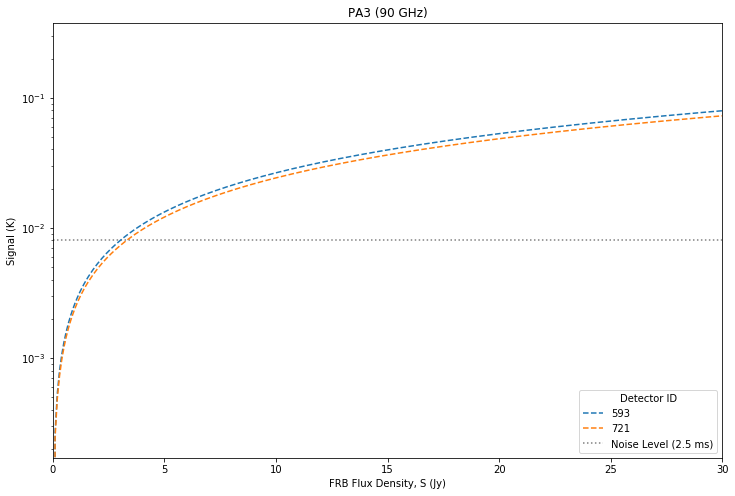

In [164]:
# Signal Range in Jansky:
Signal_Range = np.linspace(0, 100, 1000)

# Duration Range in Milliseconds:
Duration_Range = np.linspace(1, 10, 5)

plt.figure(figsize=(12,8))

print pixels
print 'XY Coordinates of Pixels in Degrees:'

distance = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]
#l = random.choice(distance)
l = 2.
print 'Distance of signal 1/', l
print '\n'
for i,j in enumerate(pixels):
    x = sky_x[pixels[i]]
    y = sky_y[pixels[i]]
    z = .055 #dist between adjacent detectors
    omega_tot = Solid_Angle_MC([0, 0.9/l], [0, 2*np.pi], Beam_PA3_90)
    omega_part = Solid_Angle_MC([0.00, z/l], [0, 2*np.pi], Beam_PA3_90)
    omega_ratio = omega_part/omega_tot
    plt.plot(Signal_Range, Brightness_Temperature(Signal_Range, 90, 5.18162844559e-07)*omega_ratio/2.,'--', label=str(j))
    print j, ':', x, y
    print 'Omega Ratio:', omega_ratio
    print '\n'

plt.hlines(Detector_Noise(2.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dotted', label='Noise Level (2.5 ms)')    
#plt.hlines(Detector_Noise(7.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dashed', label='T = 7.5 ms')
#plt.hlines(Detector_Noise(15), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='solid', label='T = 15 ms')

plt.yscale('log')
plt.xlim([0, 30])

plt.xlabel('FRB Flux Density, S (Jy)')
plt.ylabel('Signal (K)')

plt.title ('PA3 (90 GHz)')
plt.legend(title='Detector ID',loc=4)
plt.show()

### Define a `timeseries` function to return the time profile of an FRB candidate
This function is set to return the timeseries for 90GHz data from an event.
<br>
Currently, it is not being used to plot anything, but it may be useful later if you need to see the time profile and verify that the glitch is correctly classified as an FRB candidate


In [165]:
def timeseries(pixel_id, s_time, e_time, buffer=10):
    start_time = s_time - buffer
    end_time = e_time + buffer
    a1, a2 = pr.get_f1(pixel_id)
    d1, d2 = tod_data.data[a1], tod_data.data[a2]
    # try to remove the mean from start_time to end_time                                                                                                     
    d1 -= np.mean(d1[start_time:end_time])

    time = tod_data.ctime - tod_data.ctime[0]
    time = time[start_time:end_time]

    d_1 = d1[start_time:end_time]

    return time, d_1

## Randomly Generate a Location for an FRB Event to Take Place on the Detector Array

This next block of code will plot the detector array (in red), the pixels affected in the event (in blue) and a randomly generated location for an FRB event to take place (in green). 
<br>
The block of code after that will visualize the generated signal affecting the detector on the $xyz$-plane. 
This will be later used to understand how detectors at different distances from the event detect the event and what is the threshold distance for detecting an FRB event.

Center of Generated Signal, xy: -0.369391997286 0.224613236729


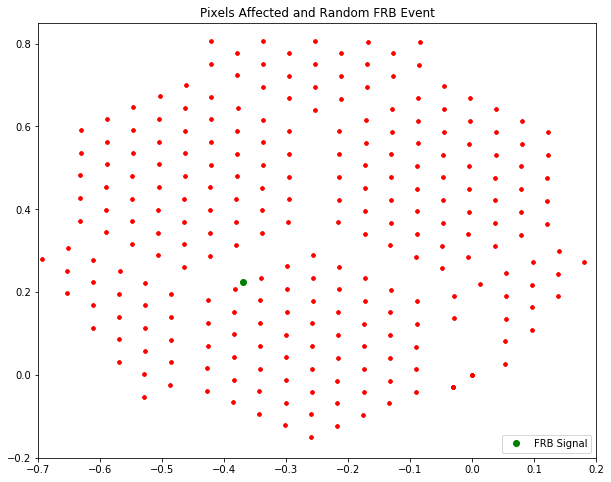

In [179]:
plt.figure(figsize=(10,8))

# xc and yc are the center of the randomly generated signal 
xc,yc = np.random.uniform(-0.7,0.2),np.random.uniform(-0.2,0.85)
print 'Center of Generated Signal, xy:', xc, yc
plot_pixels(pixels)
plt.plot(xc,yc,'go',label="FRB Signal")
plt.title('Pixels Affected and Random FRB Event')
plt.xlim(-0.7,0.2)
plt.ylim(-0.2,0.85)
plt.legend(loc=4)
plt.show()

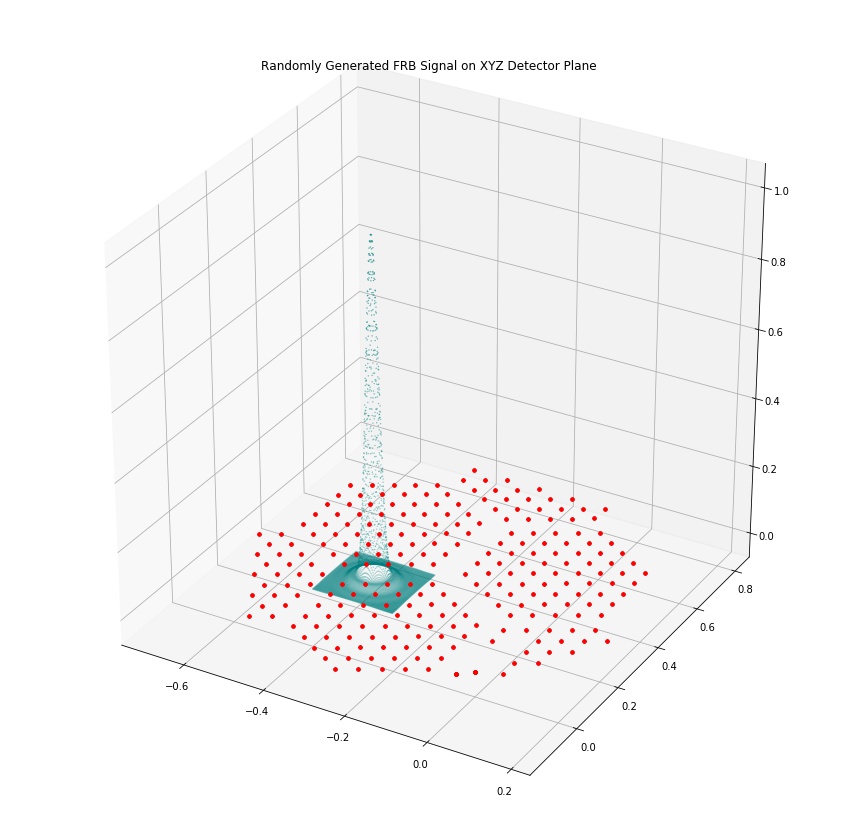

In [180]:
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm

"""
For Reference:
pa3_90x = Beam_PA3_90[0]
pa3_90y = Beam_PA3_90[1]
x = np.linspace(min(pa3_90x),max(pa3_90x),1000)
beam_profile = si.interp1d(pa3_90x,pa3_90y)
"""

x_new = np.linspace(xc-.1,xc+.1,100)
y_new = np.linspace(yc-.1,yc+.1,100)
#plt.plot(x_new,y_new)
xz,yz = np.meshgrid(x_new,y_new)
minx,maxx = np.min(xz),np.max(xz)
miny,maxy = np.min(yz),np.max(yz)

#subtract off the center point to displace the distribution
r = np.sqrt((xz-xc)**2 + (yz-yc)**2)
z = beam_profile(r)


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
plot_pixels()
plt.title('Randomly Generated FRB Signal on XYZ Detector Plane')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=.1)
#plt.savefig('Random_beam_on_detector.png')
plt.show()


In [181]:
def MonteCarlo_double(f, g, x_olim, y_olim, x_lim, y_lim, n):
    """
    #-------------------------------------------------#
    # Description:                                    #
    # Monte Carlo integration of f over a domain g>=0,#
    # n^2 is the number of random points.             #
    #                                                 #
    # Parameters:                                     #
    # f: integrand function                           #
    # g: function that decides which points are       #
    #    within bounds                                #
    # x_olim, y_olim: lists of overshot bounds of     #
    #                 integration                     #
    # x_lim, y_lim: lists of actual bounds of         #
    #               integration                       #
    # n: number of points to define intgration grid   #
    #-------------------------------------------------#
    """
    #Unpack Variables
    x0,x1 = x_olim[0],x_olim[1]
    y0,y1 = y_olim[0],y_olim[1]
    x_0,x_1 = x_lim[0],x_lim[1]
    y_0,y_1 = y_lim[0],y_lim[1]
    
    # Draw n**2 random points in the area of integration  
    x = np.random.uniform(x0, x1, n)
    y = np.random.uniform(y0, y1, n)
    
    # Compute sum of f values inside the integration domain
    f_mean = 0
    num_inside = 0   # number of x,y points inside domain (g>=0)
    for i in range(len(x)):
        for j in range(len(y)):
            if g(x[i], y[j],x_lim,y_lim) >= 0:
                num_inside += 1
                f_mean += f(x[i], y[j])
    f_mean = f_mean/float(num_inside)
    area = num_inside/float(n**2)*(x1 - x0)*(y1 - y0)
    return area*f_mean

def g(x, y,x_lim,y_lim):
    
    """
    x_lim: list of starting and ending bounds of x-integration
    y_lim: list of starting and ending bounds of y-integration
    """
    x0,x1 = x_lim[0],x_lim[1]
    y0,y1 = y_lim[0],y_lim[1]
    return(1 if (x0 <= x <= x1 and y0 <= y <= y1) else -1)
    
(MonteCarlo_double(lambda xz,yz: beam_profile(np.sqrt((xz-xc)**2 + (yz-yc)**2)),g, [minx-0.5,maxx+0.5],[miny-0.5,maxy+0.5],[minx,maxx],[miny,maxy],100))



0.0007467346234868245

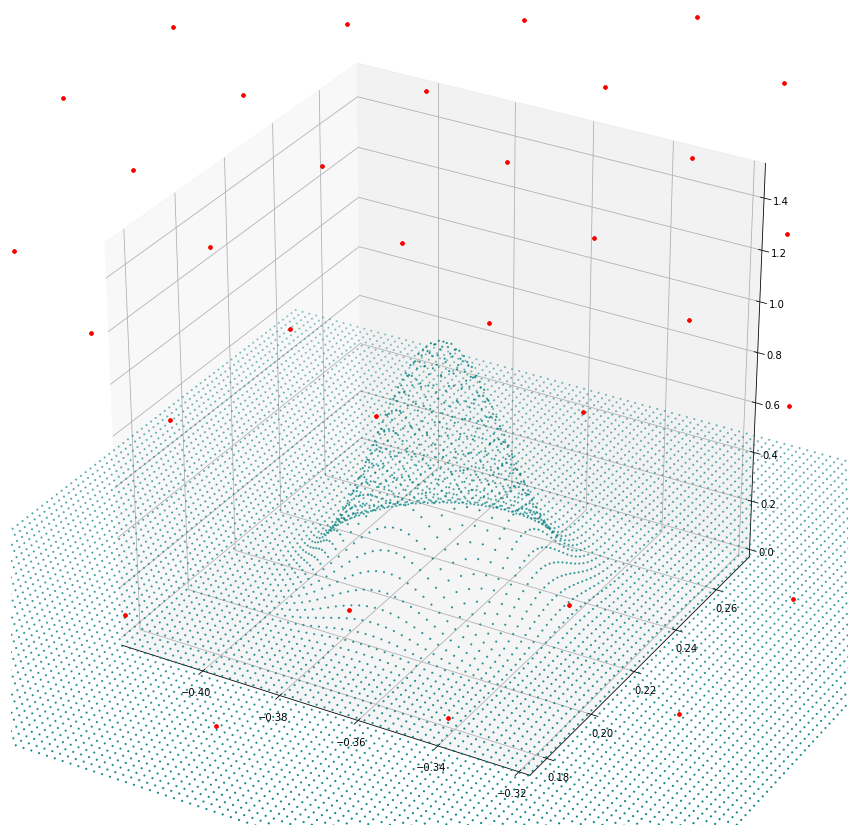

In [182]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=1.5)
plot_pixels()
ax.set_xlim(xc-.05, xc+.05); ax.set_ylim(yc-.05, yc+.05); ax.set_zlim(0, 1.5);
plt.show()

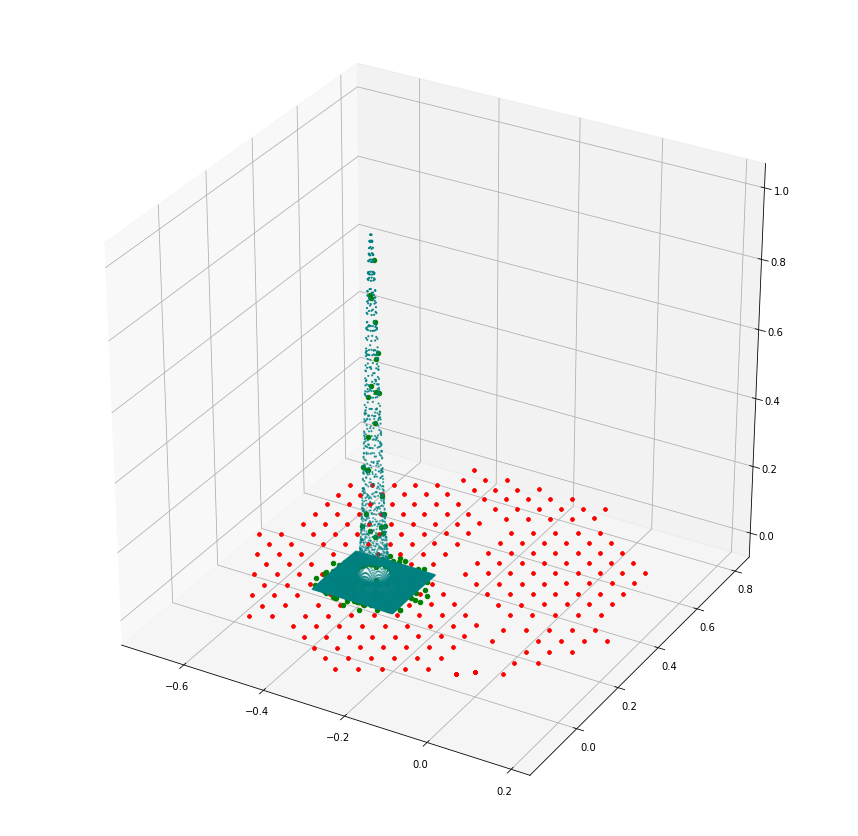

In [183]:
"""
VARIABLES ALREADY DEFINED FOR REFERENCE
x_new = np.linspace(xc-.1,xc+.1,100)
y_new = np.linspace(yc-.1,yc+.1,100)
xz,yz = np.meshgrid(x_new,y_new)

#subtract off the center point to displace the distribution
r = np.sqrt((xz-xc)**2 + (yz-yc)**2)
z = beam_profile(r)
"""
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=1.5)
plot_pixels()
#ax.set_xlim(xc-.05, xc+.05); ax.set_ylim(yc-.05, yc+.05); ax.set_zlim(0, 1.5);

th = np.linspace(0,2*np.pi,100)
x_rad = np.linspace(xc - 0.07,xc + 0.07, 100)
y_rad = np.linspace(yc - 0.07,yc + 0.07, 100)
for n in range(250):
    xrad, yrad = np.random.choice(x_new),np.random.choice(y_new)
    #print 'xy =', xrad, yrad
    #xrad = np.random.choice(np.arange(0,100),p=[beam_profile(i) for i in abs(x_new)])
    #yrad = np.random.choice(np.arange(0,100),p=[beam_profile(i) for i in abs(y_new)])
    rpol = np.sqrt((xrad-xc)**2 + (yrad-yc)**2)
    #print 'radius =',rpol
    theta = np.random.choice(th)
    #print 'theta =', theta
    zpol = beam_profile(rpol)
    #print zpol
    xpol = rpol*np.cos(theta)
    ypol = rpol*np.sin(theta)
    ax.scatter(xc+xpol,yc+ypol,zpol,c='green',s=20)

plt.show()

    

ValueError: probabilities do not sum to 1

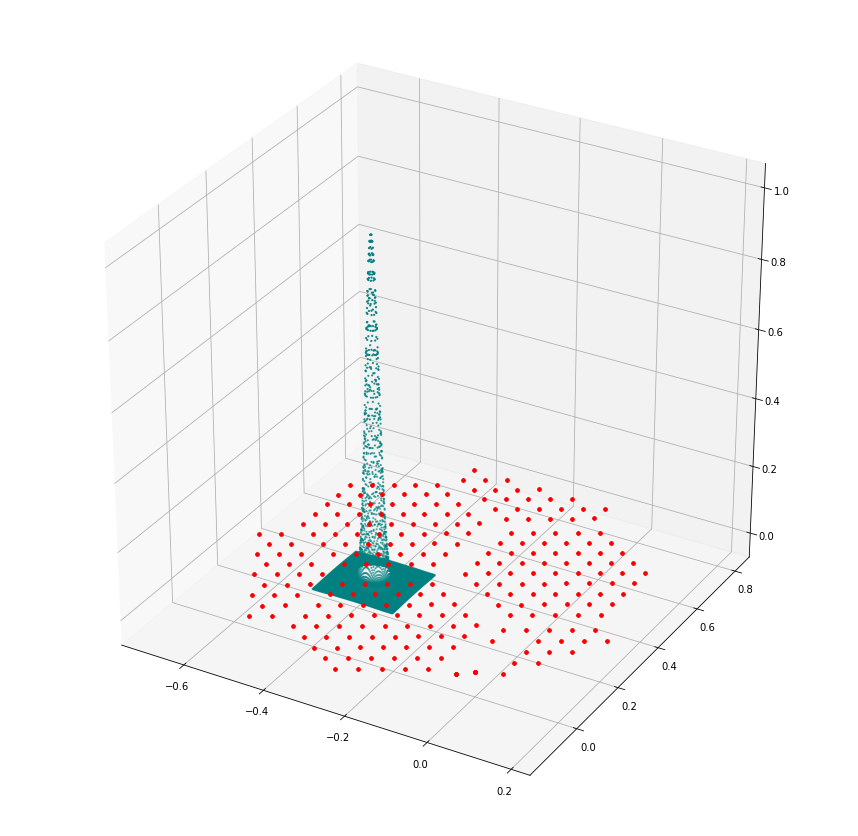

In [188]:
"""
VARIABLES ALREADY DEFINED FOR REFERENCE
x_new = np.linspace(xc-.1,xc+.1,100)
y_new = np.linspace(yc-.1,yc+.1,100)
xz,yz = np.meshgrid(x_new,y_new)

#subtract off the center point to displace the distribution
r = np.sqrt((xz-xc)**2 + (yz-yc)**2)
z = beam_profile(r)
"""
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=1.5)
plot_pixels()
#ax.set_xlim(xc-.05, xc+.05); ax.set_ylim(yc-.05, yc+.05); ax.set_zlim(0, 1.5);

r = np.linspace(-0.5, 0.5, 100)
for n in range(10):
    r_rand = np.random.choice(np.arange(0,100), p=[beam_profile(i) for i in r])
    phi = np.random * 2*np.pi
    x = xz + r_rand * np.cos(phi)
    y = yz + r_rand * np.sin(phi)
    zpol = beam_profile(r_rand)
    ax.scatter(x,y,zpol,c='green',s=20)  
plt.show()

## Generate Plots of Neighboring Pixels

For all pixels affected in an event, the following block of code will generate plots of the neighboring pixels.
This data will later be used to understand how weakly or strongly neighboring pixels detect the event. 

In [ ]:
for i in pixels:
    j = pr.get_pixels_within_radius(i,1)
    x, y = timeseries(i,stime,etime)
    base_sig = max(y)
    max_sig = []
    for n in j:
        a,b = timeseries(n,stime,etime)
        max_sig.append(max(b))
    ratios = np.asarray(max_sig)
    ratios/base_sig
    print 'Pixel Affected:', i 
    print 'Adjacent Pixels:', j
    print 'Ratios of adjacent signals:', ratios
    plt.subplot(121)
    pr.plot(i)
    
    plt.subplot(122)
    pr.plot(j)
    plt.show()
    
#x, y = timeseries(527,stime,etime)
#plt.plot(x,y)
#plt.show()